# CSE 144 Fall 2023 HW 3

In this assignment, your goal is to train Convolutional Neural Networks (CNN) to classify CIFAR-10 images. CIFAR-10 is a 10-class image classification dataset with 50,000 training images and 10,000 test images. You can find more info in https://www.cs.toronto.edu/~kriz/cifar.html. You may find more information about PyTorch usage in official documents at https://pytorch.org/tutorials/beginner/basics/intro.html.

## Instruction 

- Submit your assignments onto **Canvas** by the due date.
- This is an **individual** assignment. All help from others (from the web, books other than text, or people other than the TA or instructor) must be clearly acknowledged. 
- Don't change the input and output structure of pre-defined functions. Most coding parts can be finished with about 5-6 lines of codes.
- Remember that tuning on the test loss is prohibited.

## Rubric

The assignment is worth 40 points in total:
- Import and split dataset (5 points)
- Build dataloader (5 points)
- Build Neural Network (10 points)
    - init (5 points)
    - forward (5 points)
- Define loss and optimizer (5 points)
- Training and tesing loop (10 points)
    - training (5 points)
    - testing (5 points)
- Regularization (5 points)

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("cuda availability:", torch.cuda.is_available())

cuda availability: True


#### Step-1: Import and split dataset
Load the CIFAR-10 dataset using `torchvision.datasets.CIFAR10` and use 10% of training images as validation data.

In [2]:
transform = transforms.Compose([transforms.ToTensor()])
###### Your codes start here. ####
dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [45000, 5000])
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
###### Your codes end here. ######
assert len(train_dataset) == 45000
assert len(val_dataset) == 5000

Files already downloaded and verified
Files already downloaded and verified


#### Step-2: Build Dataloader
Build PyTorch dataloader based on the dataset. Set batchsize to 128. Remember to shuffle the training data, not the validation data!

In [3]:
###### Your codes start here. ######
# Convert datasets to DataLoader
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4)
# train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)
###### Your codes end here. ######

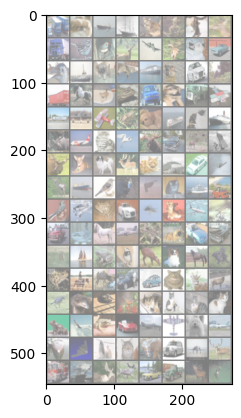

In [4]:
# Visualize one image from CIFAR
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(train_loader)
# images, labels = dataiter.next() # doesn't work for python3
images, labels = next(dataiter) # works for python3
imshow(torchvision.utils.make_grid(images))

#### Step-3: Build a neural network.
Build your convolutional neural networks by adding some layers. You should use 2 convolution layers and ReLU as the default activation function. The kernel size of both layers should be 3x3. Use 32 and 64 as the number of filters for the first and the second convolutional layers, respectively. Set their stride to be 2. After that, flatten your input and add two more dense layers. There should be 1024 units in the first dense with ReLU activation, and use 10 hidden units in the second dense layer with softmax activation. The requirements are same for the following questions.

In [5]:
class SimpleCNN(nn.Module):
    def __init__(self):
    ###### Your code starts here. ######
        # layer definition
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, stride=2)
        self.conv2 = nn.Conv2d(32, 64, 3, stride=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * 7 * 7, 1024) 
        self.fc2 = nn.Linear(1024, 10)
    ###### Your codes end here. ######

    def forward(self, x):
    ###### Your code starts here. ######
    # forwarding definition
        # CONVOLUTION LAYER 1
        x = F.relu(self.conv1(x))
        # CONVOLUTION LAYER 2
        x = F.relu(self.conv2(x))
        # FLATTEN
        x = self.flatten(x)
        # FULLY CONNECTED LAYER 1
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = F.softmax(x, dim=1)
        return x
    ###### Your codes end here. ######

model = SimpleCNN().to(device)

#### Step-4: Define loss and optimizer.
use cross_entropy loss and stochastic gradient descent optimizer. Set lr=0.01 and momentum=0.9.

In [6]:
###### Your code starts here. ######
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
###### Your code ends here. ######

#### Step-5: Training and testing loop.
train your model for 20 epochs. The requirements are same for the following questions. If you do not have access to powerful GPUs, it might take 5-10 minutes to finish one epoch. If you feel you are waiting too long, try smaller networks and less epochs for debugging. But DO NOT forget restore your network definition code and n_epochs to its correct form!

In [7]:
# Training loop
def train_loop(model, train_loader, val_loader, criterion, optimizer):
    n_epochs = 20
    # n_epochs = 1    # for debug
    for epoch in range(n_epochs):
        model.train()
        for inputs, labels in train_loader:
            ###### Your code starts here. ######
            # do forward-backward propogation, and update the model
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            ###### Your code starts here. ######

        # Validation
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                ###### Your code starts here. ######
                # compute the validation loss and accuracy
                val_loss += criterion(outputs, labels).item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                ###### Your code starts here. ######
                correct += (predicted == labels.squeeze()).sum().item()

        print(f'Epoch {epoch+1}/{n_epochs}, Loss: {val_loss/len(val_loader):.4f}, Accuracy: {correct/total:.4f}')

In [8]:
# Evaluation
def test_loop(model, test_loader, criterion):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            ###### Your code starts here. ######
            # compute the validation loss and accuracy
            # should be the same as the code for validation set
            test_loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            ###### Your code starts here. ######
            correct += (predicted == labels.squeeze()).sum().item()

    print(f'Test Loss: {test_loss/len(test_loader):.4f}, Test Accuracy: {correct/total:.4f}')


#### Step-6 Regularization
Add one dropout layer with 0.5 drop rate between the two dense layer. You can keep all other hyperparameters the same.

In [9]:
class SimpleCNN(nn.Module):
    def __init__(self):
    ###### Your code starts here. ######
    # layer definition
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, stride=2)
        self.conv2 = nn.Conv2d(32, 64, 3, stride=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * 7 * 7, 1024)
        self.fc2 = nn.Linear(1024, 10)
        self.dropout = nn.Dropout(0.5)
    ###### Your codes end here. ######

    def forward(self, x):
    ###### Your code starts here. ######
    # forwarding definition
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.log_softmax(self.fc2(x))
        return x
    ###### Your codes end here. ######

model = SimpleCNN().to(device)

In [10]:
###### Your code starts here. ######
# do not forget to redefine the loss and optimizer!
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
###### Your code ends here. ######

In [11]:
train_loop(model, train_loader, val_loader, criterion, optimizer)
test_loop(model, test_loader, criterion)
# the right implementation should lead to an accuracy boost of at least 1.5%, on both val and test set

C:\Users\Michael\AppData\Local\Temp\ipykernel_23780\1525139081.py:22: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(self.fc2(x))


Epoch 1/20, Loss: 1.7313, Accuracy: 0.3856
Epoch 2/20, Loss: 1.5085, Accuracy: 0.4670
Epoch 3/20, Loss: 1.4022, Accuracy: 0.4944
Epoch 4/20, Loss: 1.3226, Accuracy: 0.5248
Epoch 5/20, Loss: 1.2413, Accuracy: 0.5576
Epoch 6/20, Loss: 1.2368, Accuracy: 0.5566
Epoch 7/20, Loss: 1.1502, Accuracy: 0.5880
Epoch 8/20, Loss: 1.1169, Accuracy: 0.6042
Epoch 9/20, Loss: 1.1012, Accuracy: 0.6156
Epoch 10/20, Loss: 1.0812, Accuracy: 0.6208
Epoch 11/20, Loss: 1.0555, Accuracy: 0.6312
Epoch 12/20, Loss: 1.0343, Accuracy: 0.6446
Epoch 13/20, Loss: 1.0631, Accuracy: 0.6336
Epoch 14/20, Loss: 1.0610, Accuracy: 0.6452
Epoch 15/20, Loss: 1.0426, Accuracy: 0.6522
Epoch 16/20, Loss: 1.0545, Accuracy: 0.6506
Epoch 17/20, Loss: 1.1050, Accuracy: 0.6530
Epoch 18/20, Loss: 1.0830, Accuracy: 0.6526
Epoch 19/20, Loss: 1.1295, Accuracy: 0.6488
Epoch 20/20, Loss: 1.1411, Accuracy: 0.6540
Test Loss: 1.1600, Test Accuracy: 0.6568
